# Image Classifier

## Load & install necessary libraries

In [1]:
import numpy as np                          
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors . limiting GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    

tf.config.list_physical_devices('GPU')

[]

## Remove broken images

In [4]:
import cv2
import imghdr

C:\Users\user\AppData\Local\Temp\ipykernel_9372\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [7]:
# tf function that reshape and prepare image data
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [8]:
#help us to use the data and grab batches
data_n = data.as_numpy_iterator()
batch = data_n.next()  #get new batch

In [9]:
# 1 - images as arrays (inputs) , 2- labels
len(batch)

2

In [10]:
print(batch[0].shape , batch[1])

(32, 256, 256, 3) [0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1]


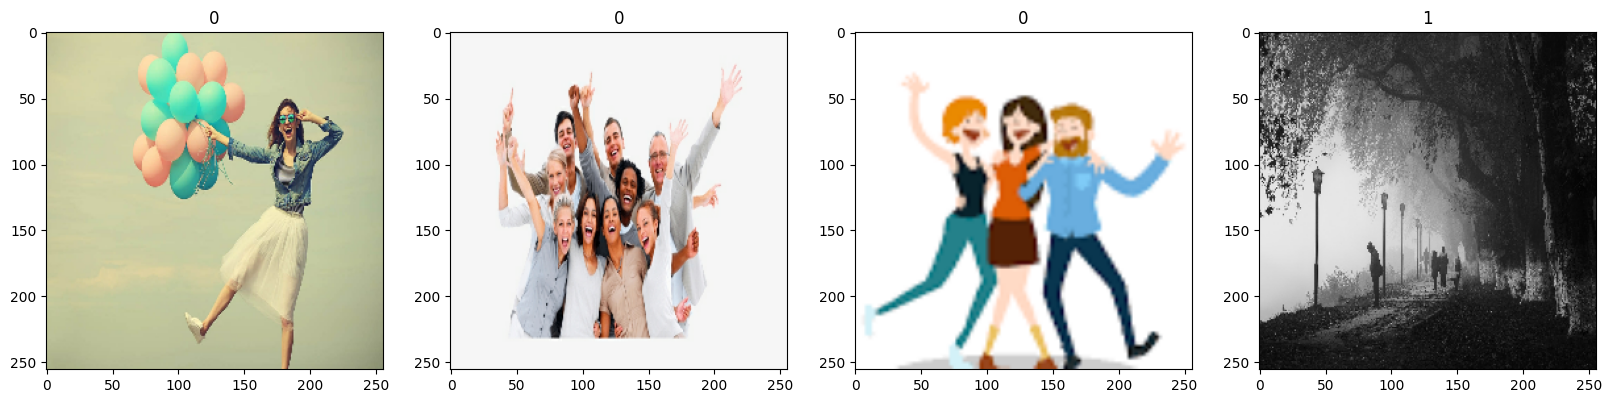

In [12]:
# check the labels (0 & 1) - Class[1] is sad , Class[0] is happy !
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for index, img in enumerate(batch[0][:4]):
    ax[index].imshow(img.astype(int))
    ax[index].title.set_text(batch[1][index])

## Prepare Data

In [13]:
#scaling is needed
print(batch[0].min(), batch[0].max()) 

0.0 255.0


In [14]:
# Scale the data b/n 0 and 1
data = data.map(lambda x,y: (x/255, y))
data.as_numpy_iterator().next()[0].max()

1.0

## Split Data

In [15]:
len(data) # 10 batches x 32

10

In [16]:
# test , train and validation split
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building Neural Network

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [19]:
model = Sequential()

model.add(Conv2D(16, (4,4), 1, activation='relu', input_shape=(256,256,3))) #img shape
model.add(MaxPooling2D()) #condense information

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten()) #condense to single demention
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #binary output

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 253, 253, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Train Model

In [24]:
#log your traning
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
history = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 24s 2s/step - loss: 0.8136 - accuracy: 0.4866 - val_loss: 0.6716 - val_accuracy: 0.4531
Epoch 2/20
7/7 [==============================] - 14s 2s/step - loss: 0.6701 - accuracy: 0.5759 - val_loss: 0.6397 - val_accuracy: 0.7500
Epoch 3/20
7/7 [==============================] - 16s 2s/step - loss: 0.6587 - accuracy: 0.6429 - val_loss: 0.6280 - val_accuracy: 0.8594
Epoch 4/20
7/7 [==============================] - 15s 2s/step - loss: 0.5499 - accuracy: 0.7991 - val_loss: 0.6796 - val_accuracy: 0.6094
Epoch 5/20
7/7 [==============================] - 15s 2s/step - loss: 0.4749 - accuracy: 0.7991 - val_loss: 0.3788 - val_accuracy: 0.8125
Epoch 6/20
7/7 [==============================] - 14s 2s/step - loss: 0.4044 - accuracy: 0.8348 - val_loss: 0.4401 - val_accuracy: 0.7500
Epoch 7/20
7/7 [==============================] - 16s 2s/step - loss: 0.3841 - accuracy: 0.7991 - val_loss: 0.4453 - val_accuracy: 0.7656
Epoch 8/20
7/7 [==================

## Plot the performance

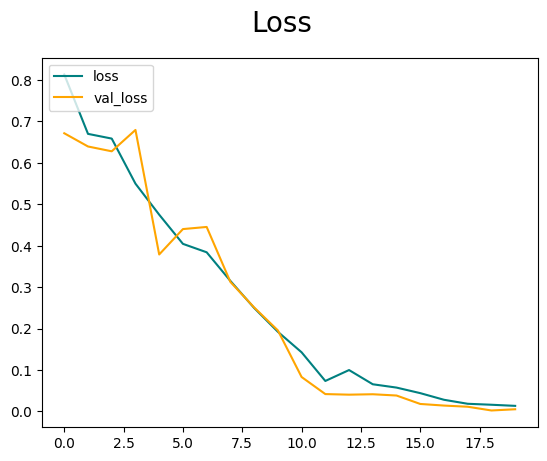

In [29]:
# LOSS
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

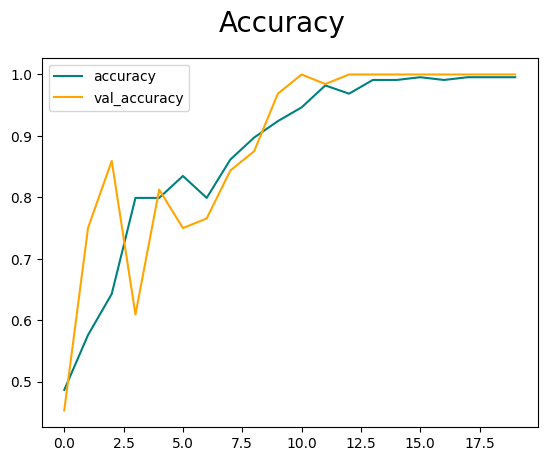

In [31]:
#accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate performance

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [33]:
prec = Precision()
rec = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    prec.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 457ms/step


In [37]:
print(prec.result(), rec.result(), acc.result()) #All is good

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


## Test the model with new data 

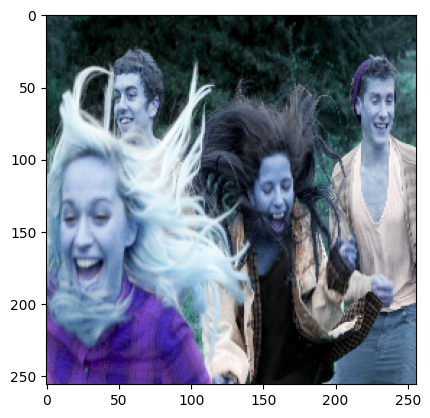

In [42]:
img = cv2.imread('happy_test.jpg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [46]:
#resize and scale
yhat = model.predict(np.expand_dims(resize/255, 0)) 
yhat #below 0.5 is happy , so it`s correct


1/1 [==============================] - 0s 51ms/step


array([[0.00352777]], dtype=float32)

## Save the model

In [47]:
from tensorflow.keras.models import load_model


In [52]:
model.save(os.path.join('models','imageclassifier.h5'))

In [54]:
# LOAD MODEL
# new_model = load_model('imageclassifier.h5')
# new_model.predict(np.expand_dims(resize/255, 0))